In [1]:
# Main imports
import numpy as np 
import pandas as pd 
import os
import cv2
from tqdm import tqdm_notebook
import gc

from warnings import filterwarnings

# ML Imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# from keras.applications.vgg19 import VGG19
# from keras.applications.mobilenet import MobileNet
from keras.models import Model, Sequential
import keras.backend as K
import keras.layers as L


filterwarnings('ignore')

PATH = ''
IMAGE_PATH = 'chestImagesBiClass/'
RND_SEED = 13

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type

### Extracting CNN Features

In [2]:
# Building separate models to extract decaf features from the intermidiate layer of VGG19
def build_decaf(net, i):
    decaf = Model(inputs=net.input,outputs=net.layers[i].output)
    return decaf

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# Create a CNN model for feature extraction

input_shape = (224, 224, 3)
model = Sequential()
model.add(L.Conv2D(32, (3, 3), input_shape=input_shape, activation = 'relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(32, (3, 3), activation = 'relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Conv2D(64, (3, 3), activation = 'relu'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))

model.add(L.Flatten())
model.add(L.Dense(256, activation = 'relu'))
model.add(L.Dense(128, activation = 'relu'))
model.add(L.Dense(32, activation = 'relu'))
model.add(L.Dense(1, activation = 'sigmoid'))
    
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
from keras.utils import to_categorical
images = []
labels = []

# Extract data and labels from 2 file folders
image_paths = []
for img in tqdm_notebook(os.listdir(IMAGE_PATH + 'NORMAL/')):
    image_paths.append(IMAGE_PATH + 'NORMAL/' + img)
    im = cv2.imread(IMAGE_PATH + 'NORMAL/' + img)
    im = cv2.resize(im, (224, 224)).reshape(224, 224, 3)
    images.append(im)
    labels.append(0)
    
for img in tqdm_notebook(os.listdir(IMAGE_PATH + 'PNEUMONIA/')):
    if np.random.rand() < 0.3:
        image_paths.append(IMAGE_PATH + 'PNEUMONIA/' + img)
        im = cv2.imread(IMAGE_PATH + 'PNEUMONIA/' + img)
        im = cv2.resize(im, (224, 224)).reshape(224, 224, 3)
        images.append(im)
        labels.append(1)
images = np.asarray(images) / 255.
labels = np.asarray(labels)

In [8]:
# Train the feature extracting CNN
model.fit(images, labels, batch_size = 32, epochs = 10, verbose = 2)

Epoch 1/10
 - 7s - loss: 0.5237 - acc: 0.7540
Epoch 2/10
 - 7s - loss: 0.2297 - acc: 0.9152
Epoch 3/10
 - 7s - loss: 0.1797 - acc: 0.9333
Epoch 4/10
 - 7s - loss: 0.1215 - acc: 0.9562
Epoch 5/10
 - 7s - loss: 0.1005 - acc: 0.9630
Epoch 6/10
 - 7s - loss: 0.0713 - acc: 0.9767
Epoch 7/10
 - 7s - loss: 0.0805 - acc: 0.9715
Epoch 8/10
 - 7s - loss: 0.0565 - acc: 0.9815
Epoch 9/10
 - 7s - loss: 0.0618 - acc: 0.9791
Epoch 10/10
 - 7s - loss: 0.0532 - acc: 0.9831


In [14]:
# Make a separate model for each of the Dense layers, to extract intermidiate layer information
decaf5 = build_decaf(model, -4)
decaf6 = build_decaf(model, -3)
decaf7 = build_decaf(model, -2)

In [16]:
# Extracting decaf5, decaf6, decaf7 features from the intermidiate layers
imageFeatures = []
for img in tqdm_notebook(image_paths):
    im = cv2.imread(img) 
    im = cv2.resize(im, (224, 224)).reshape(1, 224, 224, 3) / 255.
    decaf5_out=decaf5.predict(im)
    decaf6_out=decaf6.predict(im)
    decaf7_out=decaf7.predict(im)

    decafFeatures = np.concatenate([decaf5_out, decaf6_out, decaf7_out], axis = 1)
    imageFeatures.append(decafFeatures)
    
    
imageFeatures = np.asarray(imageFeatures)
imageFeatures = np.squeeze(imageFeatures, 1)

### Extracting GIST Features

In [19]:
import matlab
from matlab import engine
gistFeatures = []
eng = matlab.engine.start_matlab()

# Extractring GIST features from images
for img in tqdm_notebook(image_paths):
    im = cv2.imread(img)
    im = cv2.resize(im, (64, 64)) / 255
    im =  matlab.double(im.tolist())
    gist = list(eng.extract_gist(im)[0])
    gistFeatures.append(gist)
    
gistFeatures = np.asarray(gistFeatures)

### Extracting BOVW Features

In [23]:
import cv2
extractor = cv2.xfeatures2d.SIFT_create()

def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [28]:
allDescriptors = np.array([])

# Extracting SIFT features from each image
for img in tqdm_notebook(image_paths):
    im = cv2.imread(img)
    im = cv2.resize(im, (224, 224))
    keypoints, descriptors = features(im, extractor)
    if allDescriptors.shape[0] == 0:
        allDescriptors = descriptors
    else:
        allDescriptors = np.concatenate([allDescriptors, descriptors], axis = 0)
gc.collect()

53

In [40]:
from sklearn.cluster import KMeans
nFeatures = 500
km = KMeans(n_clusters = nFeatures)
km.fit(allDescriptors[:10000])
bovwFeatures = np.zeros((labels.shape[0], nFeatures))

# Combining all SIFT features into the dataset and fitting KMeans clustering to extract 1000 clusters, after that
# making a histogram for each image - which is are the gist features

for index, img in tqdm_notebook(enumerate(image_paths)):
    im = cv2.imread(img)
    im = cv2.resize(im, (224, 224))
    keypoints, descriptors = features(im, extractor)
    
    LABELS = km.predict(descriptors)
    for lab in LABELS:
        bovwFeatures[index, lab] += 1
gc.collect()

117

### Feature selection using Kruskal-Wallis non parametric test

In [41]:
from sklearn.preprocessing import LabelEncoder

# Concatenating all the features from previous steps
finalFeatures = np.concatenate([imageFeatures, gistFeatures, bovwFeatures], axis = 1)

In [79]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecting best k features using Kruskal-Wallis (ANOVA) test
selector = SelectKBest(f_classif, k=500)

selectedFeatures = selector.fit_transform(finalFeatures, labels)

### Label prediction and Model Evaluation

In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Fitting and predicting using SVM model with a non-linear kernel
model = SVC(kernel='poly')
X_train, X_test, y_train, y_test = train_test_split(selectedFeatures, labels, train_size = 0.5, random_state = RND_SEED, shuffle = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

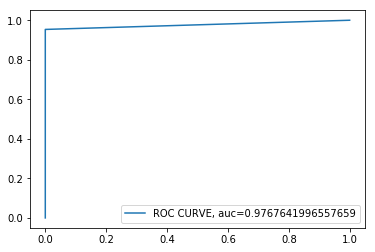

ROC AUC Score is 0.9767641996557659


In [81]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="ROC CURVE, auc="+str(auc))
plt.legend(loc=4)
plt.show()

print(f'ROC AUC Score is {auc}')